In [189]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap

df = pd.read_csv("masters_cleaned_final.csv")

print(df.head())
print(df.info())
print(df.player.value_counts())

        player  color          opponent result          event         site  \
0  Paul Morphy  white    Morphy, Alonzo    1-0    New Orleans  New Orleans   
1  Paul Morphy  white    Morphy, Alonzo    1-0    New Orleans  New Orleans   
2  Paul Morphy  white  Rousseau, Eugene    1-0    New Orleans  New Orleans   
3  Paul Morphy  white  Rousseau, Eugene    1-0    New Orleans  New Orleans   
4  Paul Morphy  white    Morphy, Alonzo    1-0  New Orleans m  New Orleans   

         date  year  eco                                  opening  plycount  
0  1848.??.??  1848  C23                         Bishop's Opening        61  
1  1848.??.??  1848  C33                   King’s Gambit Accepted        35  
2  1849.??.??  1849  C39  King’s Gambit Accepted, Allgaier Gambit        33  
3  1849.??.??  1849  C50                             Italian Game        45  
4  1849.??.??  1849  C51                             Evans Gambit        29  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8612 entries,

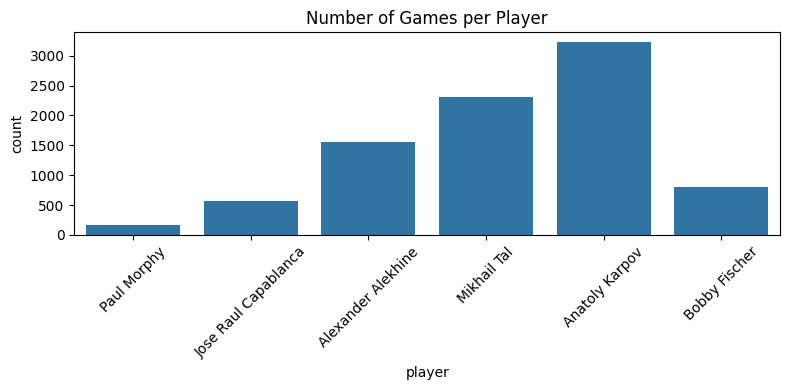

In [190]:
plt.figure(figsize=(8,4))
sns.countplot(x=df["player"])
plt.title("Number of Games per Player")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

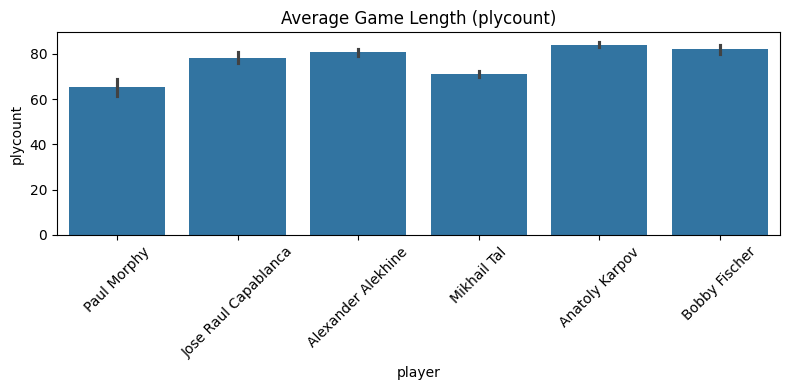

In [191]:
plt.figure(figsize=(8,4))
sns.barplot(x="player", y="plycount", data=df, estimator='mean')
plt.title("Average Game Length (plycount)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

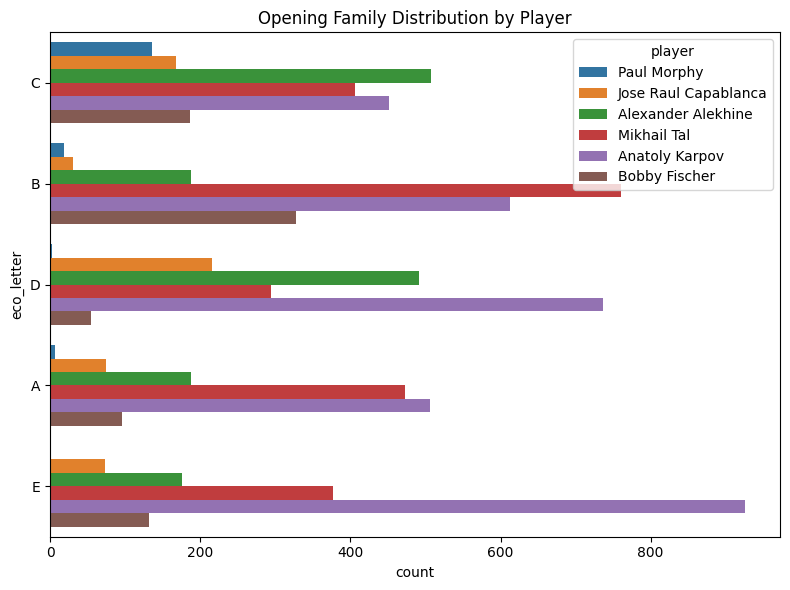

In [192]:
df["eco_letter"] = df["eco"].str[0]  # A/B/C/D/E

plt.figure(figsize=(8,6))
sns.countplot(y="eco_letter", hue="player", data=df)
plt.title("Opening Family Distribution by Player")
plt.tight_layout()
plt.show()


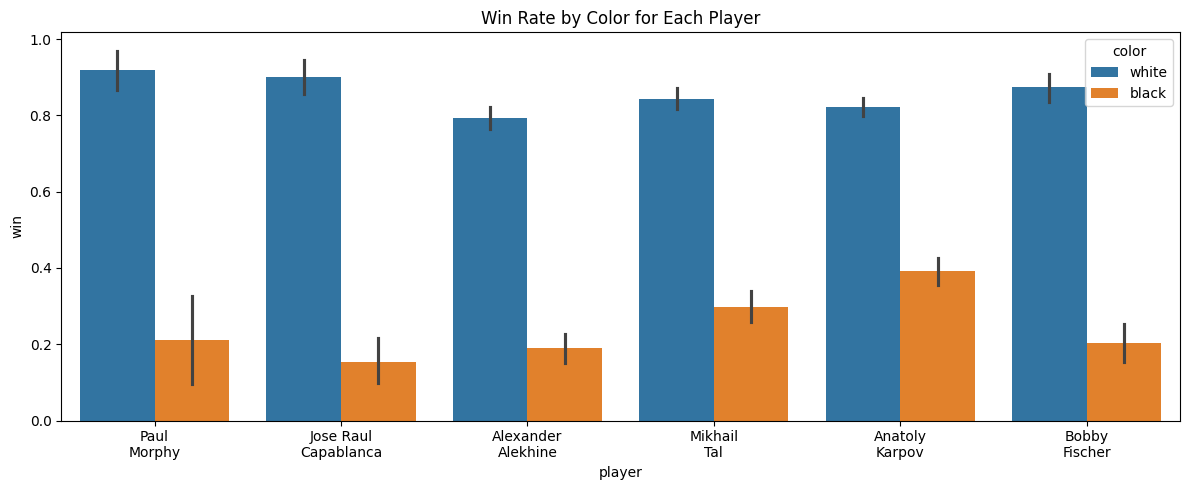

In [193]:



df["win"] = df["result"].apply(lambda x: 1 if x=="1-0" else (0 if x=="0-1" else None))


labels = [textwrap.fill(l, 10) for l in df["player"].unique()]

plt.figure(figsize=(12,5))
sns.barplot(data=df, x="player", y="win", hue="color")

plt.xticks(range(len(labels)), labels, rotation=0)
plt.title("Win Rate by Color for Each Player")
plt.tight_layout()
plt.show()


In [194]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

In [195]:
# Win = 1, Loss/Draw = 0
df["win"] = df["result"].apply(lambda x: 1 if x == "1-0" else 0)
X = df[["player", "color", "eco_letter", "plycount"]]
y = df["win"]


In [196]:
categorical_features = ["player", "color", "eco_letter"]
numeric_features = ["plycount"]

preprocessor = ColumnTransformer(
    transformers=[
        ("players_and_openings", OneHotEncoder(drop="first"), categorical_features),
        ("num", "passthrough", numeric_features),
    ]
)


In [197]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", LogisticRegression(max_iter=1000)),
    ]
)

model.fit(X_train, y_train)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('classifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('players_and_openings', ...), ('num', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the dif

In [198]:
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.6980956804458894
              precision    recall  f1-score   support

           0       0.75      0.80      0.77      1389
           1       0.59      0.51      0.55       764

    accuracy                           0.70      2153
   macro avg       0.67      0.66      0.66      2153
weighted avg       0.69      0.70      0.69      2153



In [199]:
# Define chess era based on player
def map_era(player):
    if player in ["Paul Morphy", "Jose Raul Capablanca"]:
        return "Classical Era"
    elif player == "Alexander Alekhine":
        return "Hypermodern Era"
    elif player in ["Mikhail Tal", "Anatoly Karpov"]:
        return "Soviet School"
    elif player == "Bobby Fischer":
        return "Fischer Era"
    else:
        return "Other"

df["era"] = df["player"].apply(map_era)

In [200]:
X_era = df[["color", "eco_letter", "plycount"]]
y_era = df["era"]

X_train, X_test, y_train, y_test = train_test_split(
    X_era, y_era, test_size=0.25, random_state=42, stratify=y_era
)


In [201]:
from sklearn.ensemble import RandomForestClassifier

era_model = Pipeline(
    steps=[
        ("preprocessor", ColumnTransformer(
            transformers=[
                ("categorical", OneHotEncoder(handle_unknown="ignore"),
                 ["color", "eco_letter"]),
                ("num", "passthrough", ["plycount"]),
            ]
        )),
        ("classifier", RandomForestClassifier(
            n_estimators=300,
            max_depth=10,
            class_weight="balanced",
            random_state=42
        ))
    ]
)

era_model.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('classifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('categorical', ...), ('num', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different tr

In [202]:
y_pred = era_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.3706456107756619
                 precision    recall  f1-score   support

  Classical Era       0.12      0.28      0.17       182
    Fischer Era       0.16      0.46      0.23       199
Hypermodern Era       0.28      0.32      0.29       387
  Soviet School       0.76      0.38      0.51      1385

       accuracy                           0.37      2153
      macro avg       0.33      0.36      0.30      2153
   weighted avg       0.56      0.37      0.42      2153



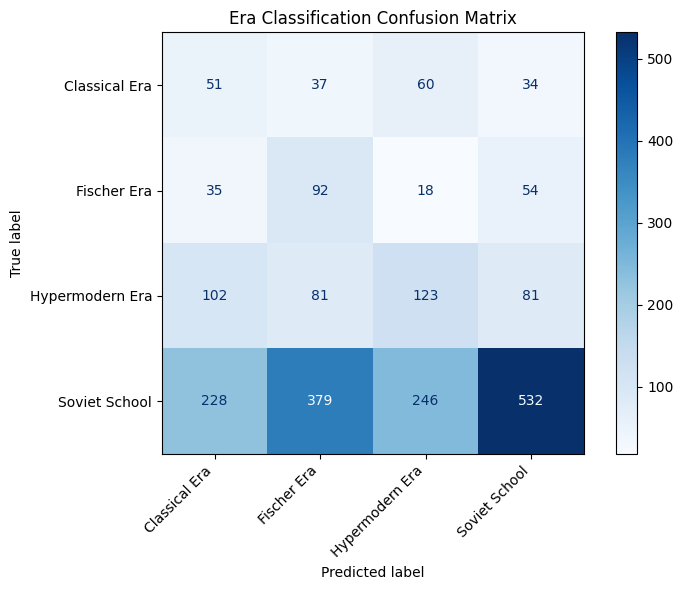

In [203]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6))

ConfusionMatrixDisplay.from_estimator(
    era_model,
    X_test,
    y_test,
    cmap="Blues",
    ax=ax
)

ax.set_title("Era Classification Confusion Matrix")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [204]:
df = pd.read_csv("move_based_features.csv")
df["era"] = df["player"].apply(map_era)

X = df.drop(columns=["player", "era"])
y = df["era"]

In [205]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

In [206]:
era_model = Pipeline(
    steps=[
        ("classifier", RandomForestClassifier(
            n_estimators=300,
            random_state=42,
            class_weight="balanced"
        ))
    ]
)

era_model.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('classifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",300
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.

In [207]:
y_pred = era_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.4533275713050994
                 precision    recall  f1-score   support

  Classical Era       0.16      0.23      0.19       202
    Fischer Era       0.17      0.37      0.23       207
Hypermodern Era       0.28      0.28      0.28       415
  Soviet School       0.70      0.54      0.61      1490

       accuracy                           0.45      2314
      macro avg       0.33      0.36      0.33      2314
   weighted avg       0.53      0.45      0.48      2314

